In [2]:
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import time
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy
import cupy

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# GPU settings
gpu_index = 0
if gpu_index >= 0:
    cuda.check_cuda_available()
    np = cuda.cupy
else:
    np = numpy

# 車輪型ロボットモデル（対向2輪型）

In [4]:
class CartLayer:
    def __init__(self,batchsize=1):
        self.cart_num = batchsize
        self.pos = Variable(np.zeros( (batchsize,3), dtype=np.float32))
        self.path = Variable(np.zeros( (batchsize,1,3), dtype=np.float32))

    def move(self,param):
        if len(param) == self.cart_num:
            dx = F.reshape(param[:,0] * F.cos(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dy = F.reshape(param[:,0] * F.sin(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dth = F.reshape(param[:,1], (self.cart_num,1))
            D = F.concat((dx,dy),axis=1)
            D = F.concat((D,dth),axis=1)
            self.pos = self.pos + D
            self.path = F.concat((self.path, F.reshape(self.pos,(self.cart_num,1,3))),axis=1)
            return self.pos
        else:
            print(len(param))
            return -1

# 連続で動く
def calc_car_pos(cart_layer, y):
    for step in range(len(y[0])):
        cart_layer.move(y[:,step])
    # print car.path.shape  # (4step, 50batch, 3x-y-th)
    # print car.pos.data.shape  # (50batch, 3x-y-th)
    return cart_layer.pos

# 経路の描画

In [5]:
def plot_path(cart_path,target,xlim=[-5,5],ylim=[-5,5]):
    path = cart_path[0,:,:]
    if gpu_index >= 0:
        path = np.asnumpy(path)
        t = np.asnumpy(target)
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    plt.scatter(t[:,0],t[:,1],c="red",s=80,marker="o")
    num_step = len(target)
    plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('scaled')
    plt.xlim(xlim[0],xlim[1])
    plt.ylim(ylim[0],ylim[1])
    plt.grid()
    plt.show()

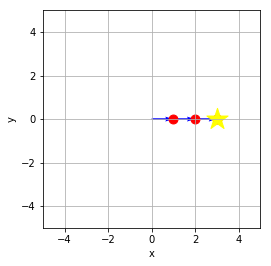

[[[0. 0. 0.]
  [1. 0. 0.]
  [2. 0. 0.]
  [3. 0. 0.]]]


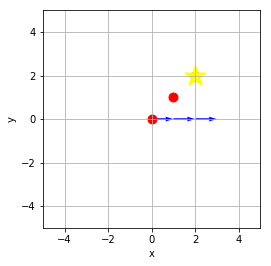

[[[0. 0. 0.]
  [1. 0. 0.]
  [2. 0. 0.]
  [3. 0. 0.]]]


In [31]:
sample_v_arr = np.array([1.0,1.0,1.0],dtype=np.float32)
sample_w_arr = np.array([0.0,0.0,0.0],dtype=np.float32)
sample_w_arr = sample_w_arr * np.pi/180
sample_y_data = np.vstack((sample_v_arr,sample_w_arr)).T
sample_yV = Variable(np.reshape(sample_y_data,(1,3,2) )) 
sample_cart = CartLayer()
pos = calc_car_pos(sample_cart,sample_yV)
plot_path(sample_cart.path.data,np.array([[1,0],[2,0],[3,0]]) )
print(sample_cart.path.data)
sample_v_arr = np.array([1.0,1.0,1.0],dtype=np.float32)
sample_w_arr = np.array([0.0,0.0,0.0],dtype=np.float32)
sample_w_arr = sample_w_arr * np.pi/180
sample_y_data = np.vstack((sample_v_arr,sample_w_arr)).T
sample_yV = Variable(np.reshape(sample_y_data,(1,3,2) )) 
sample_cart = CartLayer()
pos = calc_car_pos(sample_cart,sample_yV)
plot_path(sample_cart.path.data,np.array([[0,0],[1,1],[2,2]]) )
print(sample_cart.path.data)


# ネットワーク

In [7]:
class ModelPathGenerator(Chain):
    def __init__(self, input_dimension, num_step):
        self.input_dim = input_dimension
        self.num_step = num_step
        initializer = initializers.HeNormal()
        super(ModelPathGenerator, self).__init__(
            l1=L.Linear(self.input_dim, 15, initialW=initializer),
            l2=L.Linear(15, 8, initialW=initializer),
            l3=L.Linear(8, self.num_step*2, initialW=initializer),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = self.l3(h2)
        h4 = F.tanh(h3)
        o = F.reshape(h4,(len(x),self.num_step,2))
        return o

    '''
    def loss_function():
        path
    
    def get_vw(self,output):
        v = output[0,0:3]
        w = output[0,3:6]
        return v,w
    '''

In [8]:
# sample forward
sample_model = ModelPathGenerator(2,3)
if gpu_index >=0:
    sample_model.to_gpu()
sample_x_data = np.array([[3,0]],dtype=np.float32)
sample_x = Variable(sample_x_data)
print(sample_x_data)
sample_y = sample_model(sample_x_data)
print(sample_y)

[[3. 0.]]
variable([[[-0.14476041 -0.8101671 ]
           [ 0.2858162   0.7429408 ]
           [-0.29422736  0.088386  ]]])


# 訓練データの作成

* ある関数から経由点のcsvファイルを生成
* csvファイルから経路を生成

In [38]:
def plot_f(X,Y,color="black"):
    if gpu_index >= 0:
        x = np.asnumpy(X)
        y = np.asnumpy(Y)
    plt.scatter(x,y,c="gray",edgecolor="black",s=3,marker="o")

# ある関数を経路として生成
def make_function_path(f,x,plot=0):
    X = x
    Y = f(X)
    path = np.stack((X,Y),axis=1)
    if(plot):
        plot_f(X,Y)
    return path

# 長さと半径から曲率一定の経路を生成
def make_arc_path(l,r,plot=0):
    theta = np.linspace(-np.pi/2, -np.pi/2+l/r)
    X = r * np.cos(theta)
    Y = r * np.sin(theta) + r
    path = np.stack((X,Y),axis=1)
    if(plot):
        plot_f(X,Y)
        plt.axis('scaled')
        # plt.gca().set_aspect('equal', adjustable='box')
    return path

def make_arc_path_2(l,alpha,s=1,plot=0):
    if alpha==0:
        X = np.linspace(0, l)
        Y = np.zeros(len(X))
        path = np.stack((X,Y),axis=1)
    else:
        r = s/alpha # 曲率
        theta = np.linspace(-np.pi/2, -np.pi/2+l/r)
        X = r * np.cos(theta)
        Y = r * np.sin(theta) + r
        path = np.stack((X,Y),axis=1)
    if(plot):
        plot_f(X,Y,color="gray")
        plt.axis('scaled')
        # plt.gca().set_aspect('equal', adjustable='box')
    return path

# 経路を回転
def rotate_path(path, rad,plot=0):
    theta = rad
    X = path[:,1]*np.cos(theta) - path[:,0]*np.sin(theta)
    Y = path[:,1]*np.sin(theta) + path[:,0]*np.cos(theta)
    ret = np.stack((X,Y),axis=1)
    if(plot):
        plot_f(X,Y,color="gray")
        plt.axis('scaled')
        # plt.gca().set_aspect('equal', adjustable='box')
    return ret

# CSVから経路の読み取り
def read_path_csv(filename,plot=0):
    df = pd.read_csv(filename, header=None)
    path = np.array(df.values,dtype=np.float32)
    if(plot):
        plot_f(path[:,0],path[:,1],color="gray")
        # plt.gca().set_aspect('equal', adjustable='box')
    return path

# 経路からN点抜き出す
def get_n_point_from_path(n,path,margin=5,plot=0):
    path_data = np.empty((1,2))
    idx = 0
    for i in range(n):
        idx = idx + np.random.randint(margin,len(path)/3)
        if(idx > len(path)):
            idx = len(path)
        path_data = np.vstack((path_data,path[idx]))
    if(plot):
        plot_f(path_data[:,0],path_data[:,1],color="red")
    return path_data[1:len(path_data)]

def get_n_point_from_path_2(n,path,plot=0):
    path_data = np.empty((1,2))
    idx = [(len(path)-1)/3, (len(path)-1)*2/3, len(path)-1]
    for i in idx:
        i = int(i)
        path_data = np.vstack((path_data,path[i]))
    if(plot):
        plot_f(path_data[:,0],path_data[:,1],color="red")
    return path_data[1:len(path_data)]

'\nrand = np.random.rand() * 2 * np.pi\nx = [rand + (0.1*i) for i in range(5)]\nprint(x)\np = make_function_path(np.sin,x,plot=1)\n'

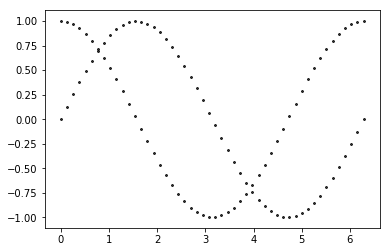

In [9]:
p = make_function_path(np.sin,np.linspace(0,2*np.pi),plot=1)
p = make_function_path(np.cos,np.linspace(0,2*np.pi),plot=1)
'''
rand = np.random.rand() * 2 * np.pi
x = [rand + (0.1*i) for i in range(5)]
print(x)
p = make_function_path(np.sin,x,plot=1)
'''

[[4.59901220e-01 8.16601187e-01]
 [1.39662119e+00 8.46639973e-01]
 [1.90985932e+00 4.82546535e-16]]


array([4.59901220e-01, 8.16601187e-01, 1.39662119e+00, 8.46639973e-01,
       1.90985932e+00, 4.82546535e-16])

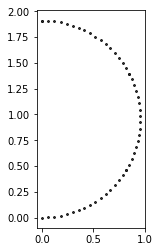

In [10]:
sample_p = make_arc_path_2(3,np.pi/3,plot=1)
sample_vp = get_n_point_from_path_2(3,sample_p,plot=1)
print(sample_vp)
sample_vp.flatten()

[[0.0000e+00 0.0000e+00 1.5976e-01]
 [1.0012e-02 1.6380e-03 1.5976e-01]
 [2.0024e-02 3.2266e-03 1.5498e-01]
 ...
 [3.3239e-03 2.9697e+00 1.6865e+00]
 [1.6183e-03 2.9848e+00 1.6801e+00]
 [0.0000e+00 3.0000e+00 1.6801e+00]]


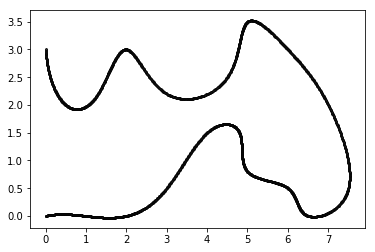

In [11]:
test_path = read_path_csv('path.csv',plot=1)
print(test_path)

(1000, 6)
[0.81781536 0.4584116  0.8535424  1.3952609  0.01186085 1.917337  ]


(-0.16128430561119564,
 3.161394368083427,
 -2.43415884298922,
 2.4341626576864863)

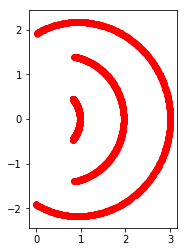

In [39]:
data_num = 1000
data_len = 3 * 2 #(3step , X-Y)

def get_path_data(data_num, data_len):
    data = np.empty((1,6),dtype=np.float32)
    l = 3 # 円弧の長さ
    for i in range(data_num):
        rand_rad = np.random.rand() * (2*np.pi/3) - np.pi/3 # 回転範囲 -60 ~ 60
        path = make_arc_path_2(l,rand_rad)
        via_path = get_n_point_from_path_2(data_len/2,path)
        data = np.vstack((data,via_path.flatten()))
        #data = np.vstack((data,[via_path]))
    return data[1:len(data)]

train_data = get_path_data(data_num,data_len)
train_data = np.array(train_data,dtype=np.float32)
print(train_data.shape)
print(train_data[0])
if gpu_index >= 0:
    td = np.asnumpy(train_data)
plt.scatter(td[:,0],td[:,1],c="red",edgecolor="red",s=30,marker="o")
plt.scatter(td[:,2],td[:,3],c="red",edgecolor="red",s=30,marker="o")
plt.scatter(td[:,4],td[:,5],c="red",edgecolor="red",s=30,marker="o")
plt.axis('scaled')

# 損失関数

In [40]:
def calc_distance(predict_pos,true_pos):
    #print "true_pos\n{}".format(true_pos.shape)
    #print "predict_pos\n{}".format(predict_pos.shape)
    D = F.sqrt(F.sum((true_pos-predict_pos)**2, axis=1))
    return D

# sample_p = Variable(np.array([[-0.04729605 , 3.132064, 0]], dtype=np.float32))
# sample_t = Variable(np.array([-0.9656074  ,1.9671886], dtype=np.float32))
# print calc_distance(sample_p[0,0:2],sample_t)
# 1.4833174

def velo_diff(v):
    # v (batch,3)
    V = np.zeros(len(v),dtype=np.float32)
    for i in range(len(v[0])-1):
        diff = v[:,i] - v[:,i+1]
        # print '{} = {} - {}'.format(diff, v[:,i], v[:,i+1])
        V = V + (diff*diff)
    init_v = np.zeros(len(v),dtype=np.float32)
    diff = init_v - v[:,0]
    # print '{} = {} - {}'.format(diff, init_v, v[:,0])
    V = V + diff*diff
    return V

# sample_p = Variable(np.array([[1, 1, 1], [2, 2, 2], [1, 1, 1]], dtype=np.float32) )
# print velo_diff(sample_p)

def terminal_cost(predict_terminal_position, true_terminal_position):
    p = predict_terminal_position
    t = true_terminal_position
    Loss = calc_distance(p,t)
    return Loss

def List_var2Variable(L):  # list内のVariableをF.concatで結合
    if(len(L) >= 2):
        V = F.concat((L[0],L[1]))
        for i in range(2,len(L)):
            V = F.concat((V,L[i]))
    else:
        V = L[0]
    return V

def stage_cost(predict_path, true_path):
    Loss = np.zeros(len(predict_path),dtype=np.float32)
    # print predict_path.shape
    # print true_path.shape
    if len(true_path[0]) < 2 or len(predict_path[0]) < 3:
        return Loss
    else:
        li_D = []
        for i in range( 1,len(predict_path[0])-1 ): # 始点と終点を除く
            # print 'ppos:{}'.format(predict_path[:,p_pos])
            # print 'tpos:{}'.format(true_path[:,t_pos])
            D = calc_distance(predict_path[:,i], true_path[:,i-1])  # D(batch)
            D = F.reshape(D,(len(D),1))
            li_D.append(D)
        Dvar = List_var2Variable(li_D)
        # print "Dmin_var\n",Dmin_var
        Loss = F.sum(Dvar, axis=1)
        return Loss
"""
def stage_cost(predict_path, true_path):
    Loss = np.zeros(len(predict_path),dtype=np.float32)
    # print predict_path.shape
    # print true_path.shape
    if len(predict_path[0]) < 2:
        return Loss
    else:
        li_Dmin = []
        for t_pos in range( 0,len(true_path[0])-1 ): # 終点を除く
            li_D = []
            for p_pos in range( 1,len(predict_path[0])-1 ): # 始点と終点を除く
                # print 'ppos:{}'.format(predict_path[:,p_pos])
                # print 'tpos:{}'.format(true_path[:,t_pos])
                D = calc_distance(predict_path[:,p_pos], true_path[:,t_pos])  # D(batch)
                D = F.reshape(D,(len(D),1))
                li_D.append(D)
            Dvar = List_var2Variable(li_D)
            # print "Dvar\n",Dvar
            Dmin = F.min(Dvar,axis=1)
            Dmin = F.reshape(Dmin,(len(Dmin),1))
            # print "Dmin\n",Dmin
            li_Dmin.append(Dmin)
        Dmin_var =  List_var2Variable(li_Dmin)
        # print "Dmin_var\n",Dmin_var
        Loss = F.sum(Dmin_var, axis=1)
        return Loss
"""

def loss_function(y, x_data):
    # y      [ batch, step,param]
    # x_data [ batch, point_x-y]
    x_data = F.reshape(x_data, (len(x_data),int(len(x_data[0])/2), 2))
    num_step = len(y[0])
    cart = CartLayer(len(y))
    calc_car_pos(cart,y)

    # Stage cost
    predict_path = cart.path[:,:,0:2] # cart.path [ batch ,step ,x-y-th]
    true_path = x_data
    Dst = stage_cost(predict_path, true_path)

    # Terminal cost
    predict_term_pos = cart.pos[:,0:2]
    true_term_pos = x_data[:,len(x_data[0])-1]
    Dtc = terminal_cost(predict_term_pos, true_term_pos)

    # Limiting
    v = y[:,:,0]
    w = y[:,:,1]
    V = velo_diff(v)
    W = velo_diff(w)
    
    # print 'Dtc :{}'.format(Dtc)
    # print 'Dst :{}'.format(Dst)
    # print 'V :{}, v:{}'.format(V,v)
    # print 'W :{}, w:{}'.format(W,w)
    Dtc = F.mean(Dtc) # terminate cost
    Dst = F.mean(Dst) # stage cost
    V = F.mean(1 * V)
    W = F.mean(1 * W)
    loss = Dtc + Dst
    message = "\t{} \t{} \t{} \t{}".format(Dtc.data, Dst.data, V.data, W.data)
    return loss, message

In [14]:
# sample_y = Variable(np.array([[[1,0], [1,0], [2,np.pi/2]], [[-1,0], [-1,0], [-2,-(np.pi/2)]]] ,dtype=np.float32 )) # 2batch 3step v-w
# sample_x = Variable(np.array([ [[1,1],[2, 2], [3,3] ]                             , [[2,2],[1,-1],[3,3] ] ] ,dtype=np.float32 )) # 2batch 2point x-y
# print loss_function(sample_y, sample_x)

# 訓練

In [41]:
def train(x_data, max_epoch, batch_size, snapshot=10):
    input_dim = len(x_data[0])
    model = ModelPathGenerator(input_dim, num_step)
    if gpu_index >= 0:
        cupy.cuda.Device(gpu_index).use()
        model.to_gpu(gpu_index)
    opt = optimizers.Adam()
    opt.setup(model)
    train_iter = iterators.SerialIterator(x_data, batch_size)
    iterator = 0
    print("Iter. \tLoss \t\tTerm. \t\tStg. \t\tV \t\tW")
    while train_iter.epoch < max_epoch:
        train_batch = np.array(train_iter.next(),dtype=np.float32)
        x = Variable(train_batch.reshape(len(train_batch),input_dim))
        y = model(x)
        loss, msg = loss_function(y,x)
        model.cleargrads()
        loss.backward()
        opt.update()
        iterator = iterator + 1
        if (iterator % snapshot)==0:
            print(str(iterator)+"\t"+str(loss.data)+msg)
    return model

In [42]:
# Dataset
data_len = 3*2
data_size = 1000

# Parameter
batch_size = 100
max_epoch  = 2000
iteration = data_size / batch_size * max_epoch
snapshot = 100
num_step = 3
input_dim = num_step*2

# Training
start_t = time.time()
model = train(train_data, max_epoch, batch_size, snapshot)
process_time = time.time() - start_t
print('Time :{}'.format(process_time))

Iter. 	Loss 		Term. 		Stg. 		V 		W
100	4.834631	2.2534595 	2.5811715 	0.29560408 	0.44361204
200	4.1688147	1.9583633 	2.2104516 	0.3671452 	0.3617215
300	2.813243	1.6292434 	1.1839994 	2.240721 	1.1118003
400	1.3720727	0.6793074 	0.69276536 	1.2022238 	0.5198087
500	0.8537693	0.4009426 	0.45282668 	1.03849 	0.45010933
600	0.5215436	0.21612239 	0.30542126 	1.1131016 	0.43721014
700	0.324943	0.13380764 	0.19113536 	1.077832 	0.45402953
800	0.22758086	0.084647834 	0.14293303 	0.9753786 	0.28916836
900	0.17323902	0.059552383 	0.113686636 	0.96009946 	0.2427106
1000	0.18064253	0.06581601 	0.11482652 	0.96773297 	0.23189953
1100	0.17338893	0.0640706 	0.10931832 	0.9682102 	0.23652206
1200	0.166	0.06310267 	0.10289732 	0.980059 	0.23094139
1300	0.1386981	0.047176722 	0.091521375 	0.9772323 	0.22898984
1400	0.11361352	0.036307015 	0.07730651 	0.9817043 	0.19423862
1500	0.11918087	0.044395637 	0.07478523 	0.9766426 	0.19762523
1600	0.12101094	0.047632635 	0.0733783 	0.9778108 	0.20312706
1700	0

12900	0.03834908	0.026297724 	0.012051358 	0.93534636 	0.16232865
13000	0.039152745	0.026796414 	0.012356331 	0.9339246 	0.17235585
13100	0.03957178	0.027150873 	0.012420907 	0.93141645 	0.18830553
13200	0.03717886	0.026125092 	0.011053768 	0.93393064 	0.16404179
13300	0.041144714	0.028605351 	0.012539361 	0.9333555 	0.17856912
13400	0.03822865	0.026650323 	0.011578327 	0.93577534 	0.16182144
13500	0.04033046	0.027423438 	0.012907021 	0.9304968 	0.19455236
13600	0.043953363	0.031144997 	0.012808366 	0.9337494 	0.16721818
13700	0.04150718	0.029753728 	0.011753453 	0.9346568 	0.1625594
13800	0.037181616	0.026165195 	0.011016422 	0.9325988 	0.18422619
13900	0.036003254	0.0252582 	0.010745053 	0.93444306 	0.17042786
14000	0.041743755	0.029202512 	0.012541245 	0.9356903 	0.16066214
14100	0.039585516	0.027820496 	0.011765018 	0.93670726 	0.1508507
14200	0.037568145	0.025789145 	0.011779 	0.93664503 	0.15163143
14300	0.044012897	0.02962729 	0.014385609 	0.93413466 	0.16918005
14400	0.03707444

# 推論

In [43]:
def predict(model, x_test, plot=0, xlim=[-5,5],ylim=[-5,5]):
    x_data = Variable(x_test)
    y = model(x_data)
    car = CartLayer(len(y))
    predpos = calc_car_pos(car, y)
    truepos = Variable(x_test)
    loss,msg = loss_function(y, x_data)
    print("loss: {}".format(loss))
    print("v,w: \n  {}".format(y))
    print("path(x-y-th): \n  {}".format(car.path))
    print("truth(x-y-th): \n  {}".format(x_test))
    if(plot>0):
        plot_path(car.path.data, np.reshape(x_data.data, (int(len(x_data[0])/2), 2)),xlim,ylim)

In [57]:
l = 3
path = make_arc_path_2(l,0)
via_path = get_n_point_from_path_2(data_len/2,path)
sample_x_test = np.array([via_path.flatten()],dtype=np.float32)
print(via_path)

[[0.97959184 0.        ]
 [1.95918367 0.        ]
 [3.         0.        ]]


loss: variable(0.04263193)
v,w: 
  variable([[[ 9.8067844e-01 -4.2113659e-04]
           [ 9.8763448e-01 -2.6882375e-03]
           [ 9.9999970e-01  5.9596635e-03]]])
path(x-y-th): 
  variable([[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
           [ 9.8067838e-01 -4.1299957e-04 -4.2113659e-04]
           [ 1.9683081e+00 -3.4839197e-03 -3.1093741e-03]
           [ 2.9683037e+00 -6.3363509e-04  2.8502895e-03]]])
truth(x-y-th): 
  [[0.97959185 0.         1.9591837  0.         3.         0.        ]]


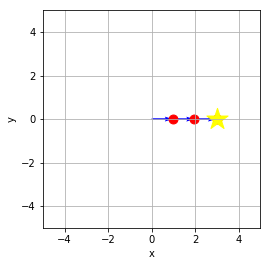

In [58]:
predict(model, sample_x_test, plot=1, xlim=[-5,5], ylim=[-5,5])

# 重みの保存と読み込み

In [48]:
# rename model
import os
import datetime

def gen_filename():
    name_date = '{0:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
    name_epoch = '{}epoch'.format(max_epoch)
    name_batch = '{}batch'.format(batch_size)
    name_datasize  = '{}data'.format(data_size)
    name_num_step = '{}step'.format(num_step)
    model_name = name_num_step+ '_' + name_datasize + name_batch + name_epoch + '_' + name_date +  '.model'
    print(model_name)
    return model_name

In [49]:
def save_pretrained(model, name):
    serializers.save_npz(name, model)

def load_pretrained(name):
    load_model = ModelPathGenerator(input_dim, num_step)
    serializers.load_npz(name, load_model)
    return load_model

In [50]:
# save
save_pretrained(model, 'tmp.model')
# os.rename('tmp.model', get_filename())

In [51]:
# Parameter
batch_size = 10
max_epoch  = 30
snapshot = 100
num_step = 3
input_dim = num_step*2
# load
load_model = load_pretrained('tmp.model')
if gpu_index >=0:
    load_model.to_gpu()

loss: variable(0.03475315)
v,w: 
  variable([[[0.9690365  0.25521606]
           [0.9760521  0.5140976 ]
           [0.99999076 0.5194981 ]]])
path(x-y-th): 
  variable([[[0.         0.         0.        ]
           [0.93764824 0.24463762 0.25521606]
           [1.6388326  0.92362076 0.76931363]
           [1.9170924  1.8841169  1.2888117 ]]])
truth(x-y-th): 
  [[0.9372015  0.24576317 1.6332023  0.9198024  1.9098593  1.9098593 ]]


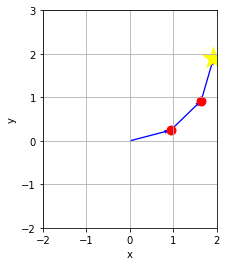

In [52]:
predict(load_model, sample_x_test, plot=1, xlim=[-2,2], ylim=[-2,3])

# 分散(未完成)

In [24]:
'''
sample_x = [1,2,3,4]
sample_y = [1,4,9,16]
sample_error = [1,4,9,16]
def plot_error(x,y,err):
    plt.plot(x,y)
    plt.errorbar(x,y,yerr=err,ecolor='r',color='b',ls='solid',lw=2,marker='o')
    plt.show()

# plot_error(sample_x,sample_y,sample_error)
'''

"\nsample_x = [1,2,3,4]\nsample_y = [1,4,9,16]\nsample_error = [1,4,9,16]\ndef plot_error(x,y,err):\n    plt.plot(x,y)\n    plt.errorbar(x,y,yerr=err,ecolor='r',color='b',ls='solid',lw=2,marker='o')\n    plt.show()\n\n# plot_error(sample_x,sample_y,sample_error)\n"

## 議事録
---

### 2019/02/19 オフィスアワー

次回まで
- PID制御と比較できるように
- 4ステップ程度の短いステップで追従
- 入江さんが作った関数を使って学習できるように  
  - 同じ結果が再現できるか確認
  - cpu用の関数になっているためgpu用に

### 2019/01/29 オフィスアワー

* 損失の計算確認
  - Reshapeが間違い
  - 速度・角速度計算の入力に間違い（参照axisがおかしかった）
* 途中経路の入力（損失の計算方法を考える
  - 経由点（入力座標）を3点に変更
  - 9ステップ先まで予測

### 2019/01/22 オフィスアワー 

* 次元ごとにforwordして結果を比較 
* lossを貯めて擬似的にmini-batch処理
* chainer SLAM 藤本さん qiita の記事?
* 同次変換行列ができれば...
* バッチ処理は先送りするのも検討
* 経路の途中の計算を諦めて評価値だけ天から降ってくるものとして扱う案
* NNで最適制御（普通の制御よりは複雑（非線形項））
* 前後左右の加減速（ドローンの風で安定しないなど）

#### 次回までの課題
* 180度を跨がない
  - -90～90度の範囲で学習
  
* tanh (-1 ~ 1)やシグモイド(正)で無茶な加減速を抑制
  - tanh層を加えた
  - 最大速度　　:１
  - 最大角速度　:

* 学習回数を増やして結果を比較
  - 今まで1000データ 5エポック
  - 今回は1000データ 50エポック

* (できたらバッチ処理)
  - 次元ごとにforwordして結果を比較した
  - lossが怪しい

### 2018/11/27
* バッチで処理 →　学習回数を増やしてデータを取る
* ネットワークを変える

### 2018/10/24　オフィスアワー

---
問題点  
* **（0,0）で動かなければ損失が少ないと学習してしまう**  
    ・極座標系で距離を一定に学習する
    
    
* **optimizers.update() **  
    ・勾配を手動計算する場合は引数不要・勾配リセットも必要  
    ・そうでない場合はloss_functionを引数に渡す

その他  
* **Variable配列の型が違って気持ち悪いので行列演算にしたい**